# REGRESSION

Что показано в проекте (кратко)
- Сгенерированы синтетические данные с известной нелинейной функцией + шум.
- Pipeline: StandardScaler → PolynomialFeatures → LinearRegression.
- GridSearchCV перебирает степени полинома (1..8) с 5-фолдовой кросс-валидацией, метрика — MSE (в sklearn как neg_mean_squared_error).
Построены два графика:
- точки данных, истинная функция и предсказание лучшей модели (плотная линия).
- средняя MSE по степеням полинома: train (по фолдам) vs test (по фолдам).
Выведены лучшие параметры, тестовая MSE и R², а также CV-оценки для лучшего эстиматора.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


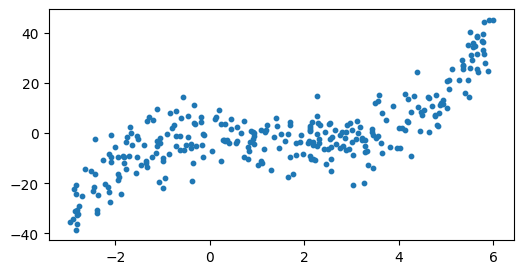

In [25]:
# Creation de donne sintetic y = 0.5 * x³ − 2x² + x + bruit
np.random.seed(0)
X = np.random.uniform(-3, 6, 300).reshape(-1, 1)
y = 0.5 * X[:, 0]**3 - 2 * X[:, 0]**2 + X[:, 0] + np.random.normal(0, 7, 300)

fig = plt.figure(figsize=(6, 3))
plt.scatter(X, y, s=10)

In [26]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Подробно: k-fold кросс-валидация (что и зачем):
Цель: получить более стабильную, менее шумную оценку качества модели на данных, чем одна случайная train/test-схема.
Процесс (k-fold, k=5 в примере):
- Делим обучающую выборку на 5 равных фрагментов (folds).
- Для каждого фолда: тренируем модель на оставшихся 4 фолдах, проверяем на отложенном фолде.
- Получаем 5 значений метрики (по одному на каждом фолде) — усредняем их.
Интерпретация:
- Средняя метрика (и её разброс) показывает, насколько модель стабильно будет работать на новых данных.
- Если разница между train_cv_score и test_cv_score большая → возможен overfitting.
Почему CV важен при подборе гиперпараметров:
- Мы используем CV внутри GridSearch, поэтому подбор параметров оценивается не на одной случайной разбивке, а «в среднем» по фолдам — это уменьшает риск выбрать переобучённый набор гиперпараметров.

In [28]:
# Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures()),
    ("model", LinearRegression())
])

# GridSearchCV pout trouver le degré polynomial
params = {
    "poly__degree": [1, 2, 3, 4, 5, 6, 7, 8],
    "poly__include_bias": [False],
    "model__fit_intercept": [True],
    }

grid = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True
)

grid.fit(X_train, y_train)

,estimator,Pipeline(step...egression())])
,param_grid,"{'model__fit_intercept': [True], 'poly__degree': [1, 2, ...], 'poly__include_bias': [False]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [36]:
results = grid.cv_results_
results["mean_test_score"]

array([-107.36228783,  -98.40449113,  -47.64167135,  -47.72761571,
        -48.1290036 ,  -48.52944058,  -48.74166837,  -49.58076866])

Подробно: GridSearchCV (как работает и ключевые опции):
- Что делает: перебирает все комбинации параметров из param_grid (здесь — разные степени полинома) и для каждой комбинации:
  - выполняет CV (k-fold), вычисляет среднюю метрику (здесь — neg_mean_squared_error), сохраняет результаты.
-Параметры:
  - param_grid — словарь параметров, указывайте имена в нотации pipeline: poly__degree.
  - cv — число фолдов или объект-генератор разбиений.
  - scoring — функция качества; для MSE в sklearn используется neg_mean_squared_error (отрицательное число потому, что sklearn ожидает, что больший — лучше). При интерпретации берем знак минус.
  - return_train_score=True — сохраняет оценки на train фолдах (полезно для диагностики over/underfitting).
  - refit=True — после подбора параметров GridSearch обучит итоговую модель на всей тренировочной выборке с найденными лучшими параметрами. Это та модель, которая доступна в grid.best_estimator_ и используется при grid.predict(...).
- Как читать cv_results_:
  - mean_test_score — средняя оценка по фолдам (знак в зависимости от scoring).
  - mean_train_score — средняя оценка на train фолдах (если включено).
  - param_* — значения перебираемых параметров для каждой строки результатов.
- Типичные ошибки и подводные камни:
  - Использовать GridSearchCV без Pipeline и делать трансформации вне CV → утечка данных (data leakage). Всегда помещайте предобработку в Pipeline.
  - Неправильно интерпретировать neg_mean_squared_error — нужно поменять знак, чтобы получить MSE.
  - Малое число фолдов (например, 2) даёт нестабильную оценку; слишком большое (LOO) — медленно и шумно при высоком разбросе. 5 или 10 — стандарт.

Если параметров много, GridSearch становится дорогостоящим → использовать RandomizedSearchCV или байесовскую оптимизацию.

In [ ]:
print("Best params:", grid.best_params_)
print("Best CV score (MSE):", -grid.best_score_)

Best params: {'model__fit_intercept': True, 'poly__degree': 3, 'poly__include_bias': False}
Best CV score (MSE): 47.64167135119267


In [ ]:
# Evaluation de model
y_pred = grid.predict(X_test)

print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test R2:", r2_score(y_test, y_pred))

Test MSE: 57.11065388222673
Test R2: 0.6725014860985066


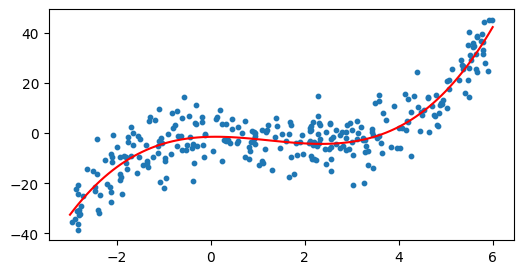

In [ ]:
X_vis = np.linspace(-3, 6, 100).reshape(-1, 1)
y_vis = grid.predict(X_vis)

fig = plt.figure(figsize=(6, 3))
plt.scatter(X, y, s=10)
plt.plot(X_vis, y_vis, color="r")


Практические рекомендации и улучшения:
- Добавить регуляризацию: Ridge / Lasso (через Ridge или Lasso), особенно если степень большая → уменьшает коэффициенты высокого порядка. В GridSearch можно добавить параметр alpha.
- Проверять разброс CV-оценок (std) — высокая дисперсия говорит о нестабильности.
- Если перебор параметров дорогой — RandomizedSearchCV.
- При работе с реальными признаками: категориальные признаки кодировать через OneHotEncoder внутри ColumnTransformer в Pipeline.
- Всегда фиксировать random_state где требуется для воспроизводимости.